In [12]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import torch
from torch import nn
import torch.nn.functional as F

In [13]:
# PyTorch'un sinir ağı modülünü kullanarak Derin Q-Ağı (DQN) modelini tanımla
class DQN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        # Girdi katmanından gizli katmana tam bağlantılı ilk katmanı tanımla
        self.fc1 = nn.Linear(input_size, hidden_size)
        # Gizli katmandan çıktı (aksiyonlar) katmanına tam bağlantılı katmanı tanımla
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # İlk katmandan sonra ReLU aktivasyon fonksiyonunu uygula
        x = F.relu(self.fc1(x))
        # Çıktı katmanı her aksiyon için ham Q-değerlerini üretir
        x = self.out(x)
        return x

In [14]:
# Deneyim tekrarında kullanılmak üzere deneyim çiftlerini saklayan Replay Memory'yi tanımla
class ReplayMemory():
    def __init__(self, maxlen):
        # Sabit boyutlu bir bellek tamponu saklamak için maxlen ile deque kullan
        self.memory = deque([], maxlen=maxlen)
    
    def append(self, transition):
        # Belleğe yeni bir deneyim çiftini ekle
        self.memory.append(transition)

    def sample(self, sample_size):
        # Eğitim için rastgele bir deneyim örneklemi al
        return random.sample(self.memory, sample_size)

    def __len__(self):
        # Belleğin mevcut boyutunu döndür
        return len(self.memory)

In [15]:
# FrozenLake ortamı için Derin Q-Öğrenme'yi (Deep Q-Learning) uygulayan ana sınıf
class FrozenLakeDQL():
    # Eğitim için hiperparametreler
    learning_rate = 0.001         # Öğrenme oranı (alfa)
    discount_factor = 0.9         # İndirim faktörü (gamma)
    sync_rate = 10                # Hedef ağı senkronize etmeden önceki adım sayısı
    replay_memory_size = 1000     # Replay memory'nin maksimum boyutu
    batch_size = 32               # Eğitim için mini-batch boyutu

    # Sinir ağı kayıp fonksiyonu ve optimize edici (daha sonra başlatılacak)
    loss_fn = nn.MSELoss()        # Ortalama Kare Hatası (MSE) kaybı
    optimizer = None              # Model oluşturulduktan sonra ayarlanacak optimize edici

    # Yazdırmak için aksiyon etiketleri (Sol, Aşağı, Sağ, Yukarı)
    ACTIONS = ['L','D','R','U']

    # FrozenLake ortamında ajanı eğit
    def train(self, episodes, render=False, is_slippery=False):
        # FrozenLake ortamı örneğini oluştur
        env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=is_slippery, render_mode='human' if render else None)
        num_states = env.observation_space.n
        num_actions = env.action_space.n
        
        epsilon = 1.0  # Epsilon-greedy politika için başlangıç epsilon'u (tamamen rastgele)
        memory = ReplayMemory(self.replay_memory_size)

        # Politika ve hedef ağlarını aynı mimariyle başlat
        policy_net = DQN(input_size=num_states, hidden_size=num_states, output_size=num_actions)
        target_net = DQN(input_size=num_states, hidden_size=num_states, output_size=num_actions)

        # Politika ağının ağırlıklarını hedef ağına kopyala
        target_net.load_state_dict(policy_net.state_dict())

        print('Politika (rastgele, eğitim öncesi):')
        self.print_dqn(policy_net)

        # Politika ağı parametreleri için optimize ediciyi başlat
        self.optimizer = torch.optim.Adam(policy_net.parameters(), lr=self.learning_rate)

        # Her bölümdeki ödülleri takip et
        rewards_per_episode = np.zeros(episodes)
        # Bölümler boyunca epsilon azalışını takip et
        epsilon_history = []

        step_count = 0  # Hedef ağı senkronize etmek için adım sayacı
            
        for episode in range(episodes):
            state = env.reset()[0]  # Ortamı sıfırla ve ilk durumu al
            terminated = False      # Bölümün bitiş bayrağı (hedefe ulaşıldı veya deliğe düşüldü)
            truncated = False       # Bölümün zaman aşımı bayrağı (maksimum adım)

            # Bölüm bitene veya zaman aşımına uğrayana kadar çalıştır
            while not terminated and not truncated:

                # Epsilon-greedy aksiyon seçimi
                if random.random() < epsilon:
                    # Rastgele aksiyon seç
                    action = env.action_space.sample()
                else:
                    # Politika ağından en iyi aksiyonu seç
                    with torch.no_grad():
                        action = policy_net(self.state_to_dqn_input(state, num_states)).argmax().item()

                # Ortamda aksiyonu uygula
                new_state, reward, terminated, truncated, _ = env.step(action)

                # Deneyimi replay memory'ye ekle
                memory.append((state, action, new_state, reward, terminated))

                # Mevcut durumu güncelle
                state = new_state

                # Adım sayacını artır
                step_count += 1

            # Bölüm için ödülü kaydet (hedefe ulaşıldıysa 1, aksi halde 0)
            if reward == 1:
                rewards_per_episode[episode] = 1

            # Yeterli örnek varsa ve en az bir ödül toplandıysa politika ağını eğit
            if len(memory) > self.batch_size and np.sum(rewards_per_episode) > 0:
                mini_batch = memory.sample(self.batch_size)
                self.optimize(mini_batch, policy_net, target_net)

                # Epsilon'u doğrusal olarak azalt
                epsilon = max(epsilon - 1/episodes, 0)
                epsilon_history.append(epsilon)

                # Belirli aralıklarla hedef ağı politika ağından senkronize et
                if step_count > self.sync_rate:
                    target_net.load_state_dict(policy_net.state_dict())
                    step_count = 0

        # Ortamı kapat
        env.close()

        # Eğitilmiş politika ağı ağırlıklarını kaydet
        torch.save(policy_net.state_dict(), "frozen_lake_dql.pt")

        # Eğitim sonuçlarını çiz
        plt.figure(1)

        # Son 100 bölümdeki ödüllerin toplamını hesapla (düzgünleştirme için)
        sum_rewards = np.zeros(episodes)
        for x in range(episodes):
            sum_rewards[x] = np.sum(rewards_per_episode[max(0, x-100):(x+1)])

        # Ödül toplamını çiz
        plt.subplot(121)
        plt.title('Bölüm Başına Ödül Toplamı')
        plt.plot(sum_rewards)

        # Epsilon azalışını çiz
        plt.subplot(122)
        plt.title('Bölümler Boyunca Epsilon Azalışı')
        plt.plot(epsilon_history)

        # Grafiği dosyaya kaydet
        plt.savefig('frozen_lake_dql.png')

    # Replay memory'den alınan mini-batch ile politika ağını optimize et
    def optimize(self, mini_batch, policy_net, target_net):
        # Girdi özelliklerinin (durumların) sayısı
        num_states = policy_net.fc1.in_features

        current_q_values = []
        target_q_values = []

        for state, action, new_state, reward, terminated in mini_batch:
            if terminated:
                # Bölüm bittiyse, hedef Q-değeri ödüldür
                target = torch.FloatTensor([reward])
            else:
                # Aksi halde, hedef Q-değeri = ödül + indirimli sonraki durumun maksimum Q-değeri
                with torch.no_grad():
                    target = torch.FloatTensor(
                        reward + self.discount_factor * target_net(self.state_to_dqn_input(new_state, num_states)).max()
                    )

            # Politika ağının mevcut durum için tahmin ettiği Q-değerleri
            current_q = policy_net(self.state_to_dqn_input(state, num_states))
            current_q_values.append(current_q)

            # Hedef ağının mevcut durum için tahmin ettiği Q-değerleri
            target_q = target_net(self.state_to_dqn_input(state, num_states))
            # Alınan aksiyonun Q-değerini hedef değere güncelle
            target_q[action] = target
            target_q_values.append(target_q)

        # Mini-batch için mevcut ve hedef Q-değerleri arasındaki kaybı hesapla
        loss = self.loss_fn(torch.stack(current_q_values), torch.stack(target_q_values))

        # Geri yayılım ve optimizasyon adımı
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    # Tamsayı durumu DQN girişi için one-hot kodlanmış tensöre dönüştür
    def state_to_dqn_input(self, state: int, num_states: int) -> torch.Tensor:
        input_tensor = torch.zeros(num_states)
        input_tensor[state] = 1
        return input_tensor

    # Eğitilmiş politikayı FrozenLake ortamında test et
    def test(self, episodes, is_slippery=False):
        # Görselleştirme ile FrozenLake ortamı örneği oluştur
        env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=is_slippery, render_mode='human')
        num_states = env.observation_space.n
        num_actions = env.action_space.n

        # Eğitilmiş politika ağını yükle
        policy_net = DQN(input_size=num_states, hidden_size=num_states, output_size=num_actions)
        policy_net.load_state_dict(torch.load("frozen_lake_dql.pt"))
        policy_net.eval()  # Ağı değerlendirme moduna al

        print('Politika (eğitilmiş):')
        self.print_dqn(policy_net)

        for episode in range(episodes):
            state = env.reset()[0]  # Ortamı sıfırla ve ilk durumu al
            terminated = False      # Bölümün bitiş bayrağı
            truncated = False       # Bölümün zaman aşımı bayrağı

            # Bölüm bitene veya zaman aşımına uğrayana kadar çalıştır
            while not terminated and not truncated:
                # Politika ağından en iyi aksiyonu seç
                with torch.no_grad():
                    action = policy_net(self.state_to_dqn_input(state, num_states)).argmax().item()

                # Ortamda aksiyonu uygula
                state, reward, terminated, truncated, _ = env.step(action)

        # Ortamı kapat
        env.close()

    # Öğrenilen politikayı yazdır: durum, en iyi aksiyon ve Q-değerleri
    def print_dqn(self, dqn):
        num_states = dqn.fc1.in_features

        for s in range(num_states):
            # Yazdırmak için Q-değerlerini 2 ondalık basamakla biçimlendir
            q_values = ''
            for q in dqn(self.state_to_dqn_input(s, num_states)).tolist():
                q_values += "{:+.2f}".format(q) + ' '
            q_values = q_values.rstrip()

            # Durum için en iyi aksiyonu al ve aksiyon etiketine eşle
            best_action = self.ACTIONS[dqn(self.state_to_dqn_input(s, num_states)).argmax()]

            # Durum, en iyi aksiyon ve Q-değerlerini FrozenLake harita düzeninde yazdır
            print(f'{s:02},{best_action},[{q_values}]', end=' ')
            if (s + 1) % 4 == 0:
                print()  # Her 4 durumda bir yeni satır

Politika (rastgele, eğitim öncesi):
00,R,[+0.09 -0.05 +0.23 +0.04] 01,R,[+0.09 -0.05 +0.18 +0.07] 02,R,[+0.09 -0.01 +0.16 +0.08] 03,R,[+0.13 -0.11 +0.17 +0.00] 
04,R,[+0.10 +0.03 +0.17 +0.05] 05,R,[+0.11 -0.03 +0.16 +0.08] 06,R,[+0.11 -0.13 +0.18 +0.05] 07,R,[+0.07 -0.13 +0.19 +0.03] 
08,L,[+0.18 -0.05 +0.15 +0.02] 09,R,[+0.08 -0.05 +0.20 +0.10] 10,R,[+0.08 -0.04 +0.23 +0.02] 11,L,[+0.15 -0.11 +0.13 +0.07] 
12,R,[+0.08 -0.00 +0.22 +0.01] 13,R,[+0.05 -0.04 +0.23 +0.07] 14,R,[+0.07 -0.04 +0.21 +0.09] 15,R,[+0.13 -0.01 +0.17 +0.02] 
Politika (eğitilmiş):
00,D,[+0.55 +0.59 +0.50 +0.53] 01,L,[+0.54 +0.18 +0.38 +0.51] 02,L,[+0.54 +0.54 +0.46 +0.43] 03,L,[+0.75 +0.30 +0.70 +0.50] 
04,D,[+0.58 +0.66 +0.01 +0.54] 05,U,[+0.42 +0.36 +0.45 +0.55] 06,L,[+0.57 +0.56 +0.46 +0.32] 07,L,[+0.58 +0.44 +0.51 +0.42] 
08,R,[+0.69 -0.00 +0.73 +0.60] 09,D,[+0.68 +0.81 +0.76 +0.03] 10,D,[+0.58 +0.90 +0.21 +0.59] 11,L,[+0.69 +0.44 +0.58 +0.61] 
12,D,[+0.48 +0.59 +0.48 +0.18] 13,R,[+0.39 +0.78 +0.90 +0.75] 14,R,

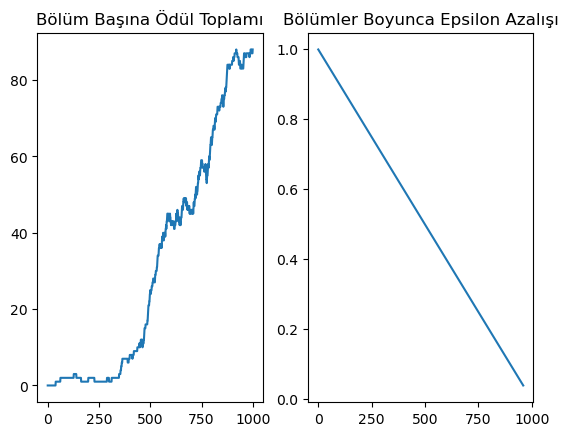

In [17]:
import warnings
warnings.filterwarnings('ignore')
frozen_lake = FrozenLakeDQL()
is_slippery = False
frozen_lake.train(1000, is_slippery=is_slippery)
frozen_lake.test(10, is_slippery=is_slippery)